# **Install cirq**

In [ ]:
!pip install -q cirq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.7/532.7 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.5/596.5 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

# **Install packages**

In [ ]:
# imports
import numpy as np
import cirq
import matplotlib.pyplot as plt
import random

# **helper functions - given in Grover's Algorithm Lab**

In [94]:
# helper functions - given in Grover's Algorithm Lab
def start_qubits(num):
  return [cirq.NamedQubit('x'+str(i)) for i in range(num)]

def print_vector(psi, register_dims = [], show_zeros = False):
    """
    Can optionally set the register dims to group qubits together.
    e.g for a three qubit state |abc>, register_dims = [1,2]
    will print as |a>|bc> while register_dims=[2,1] will print as |ab>|c>
    """
    label_size = int(np.log2(psi.size))
    if(len(register_dims) == 0):
        register_dims = [label_size]
    formatted_psi = ''
    for i in range(psi.size):
        label = format(i, '0' + str(label_size)+ 'b')
        if(show_zeros == True or psi[i].round(6) != 0):

            ket = ''
            current_ind = 0
            for s in register_dims:
                ket = ket + '|' +label[current_ind:current_ind+s]  + '>'
                current_ind = current_ind+s
            formatted_psi = formatted_psi + str(psi[i].round(3)) + ' ' + ket
            if( i < psi.size -1):
                formatted_psi = formatted_psi + ' + '

    if (formatted_psi.endswith(' + ')):
        formatted_psi = formatted_psi[0:-3]
    print(formatted_psi)

def set_initial_state(circuit, qubits, initial_state):
  """
  convenience function for setting initial state
  (since cirq always starts with |000...>)

  initial_state must be a string of 0s and 1s (e.g. '00101')
  """
  for i in range(len(initial_state)):  # set the initial state
    if initial_state[i] == '1':
      circuit.append(cirq.X(qubits[i]))

class blank_gate(cirq.Gate):
  """
  Identity gate, does nothing
  """
  def __init__(self):
      super(blank_gate, self)
  def _num_qubits_(self):
      return 1
  def _unitary_(self):
      return np.eye(2)
  def _circuit_diagram_info_(self, args):
      return ""

def show_all_qubits(circuit, qubits):
  """
  add a blank gate to every register so cirq shows all of them
  """
  for qubit in qubits:  # set the initial state
    circuit.append(blank_gate().on(qubit))

# Define the R_k gate class
class RkGate(cirq.Gate):
    def __init__(self, k: int, sign: int = 1):
        self.k = k
        self.sign = sign

    def _num_qubits_(self):
        return 1  # Single-qubit gate

    def _unitary_(self):
        phase = np.exp(self.sign * 2j * np.pi / (2 ** self.k))
        return np.array([[1, 0], [0, phase]])

    def __repr__(self):
        sign_str = "+" if self.sign == 1 else "-"
        return f"R({sign_str}{self.k})"

    def _circuit_diagram_info_(self, args):
        sign_str = "+" if self.sign == 1 else "-"
        return f"R({sign_str}{self.k})"


class CRkGate(cirq.ControlledGate):
    def __init__(self, k: int, sign: int = 1):
        super().__init__(RkGate(k, sign=sign))
        self.k = k
        self.sign = sign

    def __repr__(self):
        sign_str = "+" if self.sign == 1 else "-"
        return f"CR({sign_str}{self.k})"

    def _circuit_diagram_info_(self, args):
        sign_str = "+" if self.sign == 1 else "-"
        return f"CR({sign_str}{self.k})"



# **General antenna pattern calculator algorithm**

In [125]:
# A function

#define antennas that are on or off

def antenna_pattern(final_list, title, other=None):
    A_ref = 0
    d = 1/2  # relative to wavelength
    samples = 1000
    u = np.linspace(0, 2*np.pi, samples)

    for n in range(len(final_list)):  # Use final_list for iteration
        A_ref += final_list[n] * np.exp(-1j * 2 * np.pi * n * d * np.sin(u))

    # Polar plot
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    ax.plot(u, np.abs(A_ref), label='|A|', linewidth=2)

    # mostly for the comparison radiation pattern
    if other is not None and len(other) == samples:
        ax.plot(u, np.abs(other), label='|Reference|', linestyle='--', linewidth=2)

    # Add labels and legend
    ax.set_title(title)
    ax.legend()
    plt.show()

    return A_ref

# **Define A_ref**

[0.02671658+0.j         0.13358292+0.j         0.53433169+0.j
 0.13358292+0.26716584j 0.13358292+0.j         0.13358292+0.j
 0.53433169+0.j         0.53433169+0.j        ]


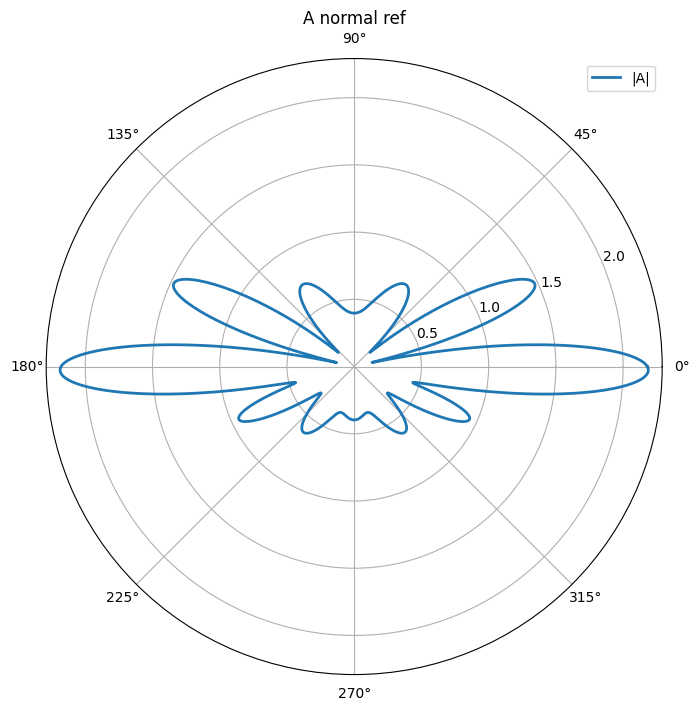

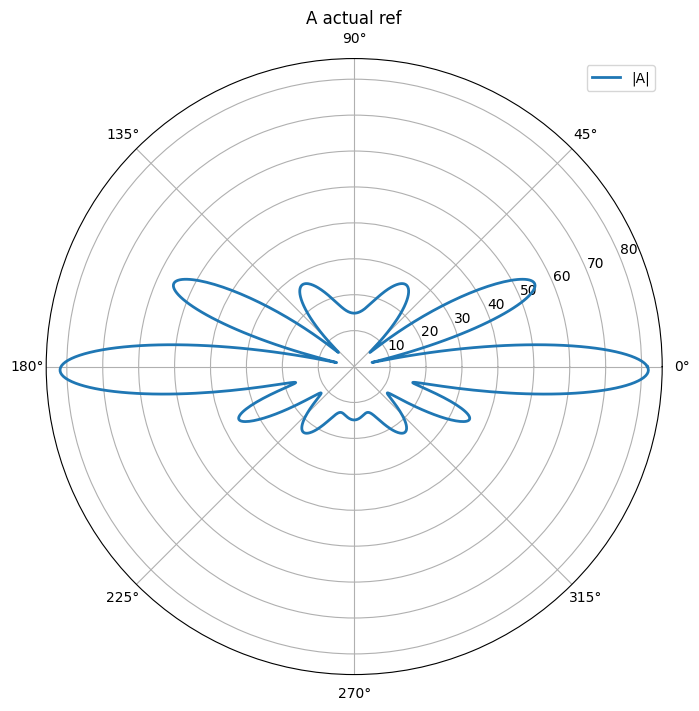

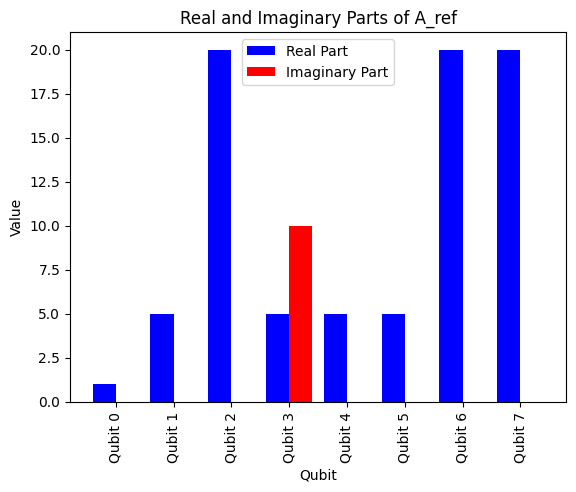

In [124]:
b_list = np.array([1, 1, 1, 1, 1, 1, 1, 1])
# b_list = np.array([1, 1])

# weight_list = np.array([1, 1j])

# weight_list = np.array([ 4.36638386+19.61054286j, 17.34334671+13.69143653j,  4.21449838+19.1466797j ,  0.51966746 +0.93011773j,  8.10904217+11.68808905j, 13.90670418+18.84883998j,  3.93457824+16.98343793j, 14.40048926 +2.62543051j])
weight_list = np.array([1, 5, 20, 5 + 10j, 5, 5, 20, 20])
final_list = np.multiply(b_list, weight_list)
final_list_normalized = final_list / np.linalg.norm(final_list)
print(final_list_normalized)
initial_state = '0' * len(b_list)
A_normalized = antenna_pattern(final_list_normalized, "A normal ref")
A_actual = antenna_pattern(final_list, "A actual ref")

# adding errors
x_error = True
z_error = True
x_error_rate = 0.002
z_error_rate = 0.005

# Separate real and imaginary parts for visualization
real_parts = np.real(weight_list)
imaginary_parts = np.imag(weight_list)

# Set up the plot
x = np.arange(len(weight_list))  # Indices for the bars

fig, ax = plt.subplots()
ax.bar(x - 0.2, real_parts, width=0.4, label='Real Part', color='b')
ax.bar(x + 0.2, imaginary_parts, width=0.4, label='Imaginary Part', color='r')

ax.set_xlabel('Qubit')
ax.set_ylabel('Value')
ax.set_title('Real and Imaginary Parts of A_ref')
ax.set_xticks(x)
ax.set_xticklabels([f'Qubit {i}' for i in range(len(weight_list))])
ax.legend()

# Show the plot
plt.xticks(rotation=90)
plt.show()

# **Take IQFT of system to get probability values**

qubit_0: Probability of |0⟩ = 0.5056544778755737
qubit_1: Probability of |0⟩ = 0.545373304478668
qubit_2: Probability of |0⟩ = 0.6563810162722917
qubit_3: Probability of |0⟩ = 0.6656578036833455
qubit_4: Probability of |0⟩ = 0.5694593239584397
qubit_5: Probability of |0⟩ = 0.610036144189054
qubit_6: Probability of |0⟩ = 0.880599584207076
qubit_7: Probability of |0⟩ = 0.9156572565390768


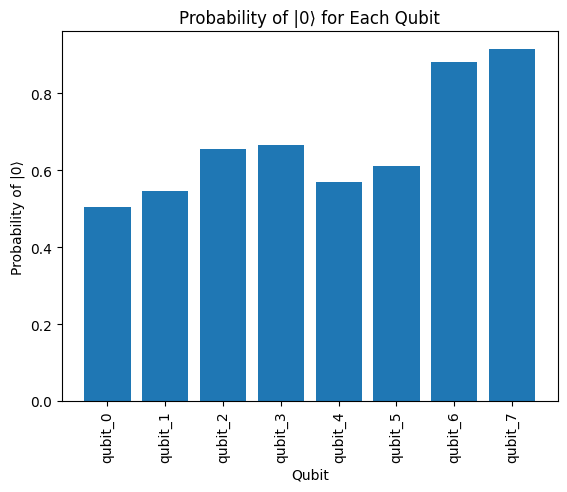

[0.5056544778755737, 0.545373304478668, 0.6563810162722917, 0.6656578036833455, 0.5694593239584397, 0.610036144189054, 0.880599584207076, 0.9156572565390768]
                                             ┌──────┐   ┌──────────┐   ┌───────────┐   ┌───────────────┐   ┌────────────────┐   ┌────────────────────┐   ┌────────────────┐   ┌───────────────┐   ┌───────────┐   ┌──────────┐   ┌──────┐
x0: ───StatePreparation[1]──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────R(-8)────────────────R(-7)───────────────R(-6)───────────R(-5)──────────R(-4)──────R(-3)────R(-2)───H───
       │                                                                                                                                        │                    │                   │               │              │          │        │
x1: ───StatePreparation[2]─────────────────────────────────────────────────────────────────────────────────────────────R(

In [121]:
# QFT algorithm. Used to make sure my IQFT was working properly
def qft(data_qubits, circuit):
  for x in range(len(data_qubits)):
    circuit.append(cirq.H(data_qubits[x]))
    for j in range(len(data_qubits)):
      if j > x:
        circuit.append(RkGate(j-x+1).on(data_qubits[x]).controlled_by(data_qubits[j]))

#IQFT algorithm.
def iqft(data_qubits, circuit, x_error, z_error, x_force, z_force):
  i = len(data_qubits) - 1
  while i >= 0:
      # Controlled phase gates applied in reverse order
      for j in range(len(data_qubits) - 1, i, -1):
          # append rotation gates with proper powers
          circuit.append(RkGate(k=(j - i + 1), sign=-1).on(data_qubits[i]).controlled_by(data_qubits[j]))
          randnum = random.random()
          # X ERROR (chance)
          if x_error and randnum <= x_error_rate:
              print(x_error)
              circuit.append(cirq.X(data_qubits[i]))
              print("X ERROR OCCURRED")
          randnum = random.random()
          # Z ERROR (chance)
          if z_error and randnum <= z_error_rate:
              circuit.append(cirq.Z(data_qubits[i]))
              print("Z ERROR OCCURRED")
          # X ERROR (forced)
          if x_force and j == i+1:
            circuit.append(cirq.X(data_qubits[i]))
            print("XXXX")
          # Z ERROR (forced)
          if z_force and j == 7:
            if i == 2:
              circuit.append(cirq.X(data_qubits[i]))
              print("X PURPOSEFUL ERROR OCCURRED")
      # Apply Hadamard gates
      circuit.append(cirq.H(data_qubits[i]))
      i -= 1

# Getting |0>
def calculate_qubit_probabilities(state_vector, nbits):
    probabilities = {}
    for qubit_index in range(nbits):
        prob_0 = 0
        prob_1 = 0
        for i, amplitude in enumerate(state_vector):
            # Binary representation of state index
            state_bin = format(i, f'0{nbits}b')
            if state_bin[qubit_index] == '0':
                prob_0 += abs(amplitude)**2
            else:
                prob_1 += abs(amplitude)**2
        probabilities[f'qubit_{qubit_index}'] = {'0': prob_0, '1': prob_1}

    #extract |0> probability
    for qubit, prob in probabilities.items():
      print(f"{qubit}: Probability of |0⟩ = {prob['0']}")
    qubit_indices = []
    prob_0_values = []
    for qubit, prob in probabilities.items():
      qubit_indices.append(qubit)
      prob_0_values.append(prob['0'])

    #plot
    plt.bar(qubit_indices, prob_0_values)
    plt.xlabel('Qubit')
    plt.ylabel('Probability of |0⟩')
    plt.title('Probability of |0⟩ for Each Qubit')
    plt.xticks(rotation=90)
    plt.show()

    return prob_0_values

# number of data qubits
nbits = len(b_list)

# preparation phase. Qubits prepared such that one qubit represents one antenna.
scaled_state_vector = np.zeros(2 ** nbits, dtype=complex)
for idx in range(2 ** nbits):
    binary_state = format(idx, f'0{nbits}b')
    scale_factor = 1
    for qubit_index, bit in enumerate(binary_state):
        if bit == '1':
            scale_factor *= final_list_normalized[qubit_index]
    scaled_state_vector[idx] = scale_factor

scaled_state_vector /= np.linalg.norm(scaled_state_vector)
data_qubits = [cirq.NamedQubit(f'x{i}') for i in range(nbits)]
state_prep_channel = cirq.StatePreparationChannel(scaled_state_vector)



circuit = cirq.Circuit()
circuit.append(state_prep_channel.on(*data_qubits))
show_all_qubits(circuit, data_qubits)
set_initial_state(circuit, data_qubits, initial_state)


# START actual code
# qft(data_qubits, circuit)
iqft(data_qubits, circuit, True, True, False, False)

simulator = cirq.Simulator()
result = simulator.simulate(circuit)

probabilities = calculate_qubit_probabilities(result.final_state_vector, nbits)
print(probabilities)
# END actual code

print(circuit)



# probabilities = calculate_qubit_probabilities(result.final_state_vector, nbits)


# **Sort the probabilities**

In [114]:
# Create a list of tuples (qubit_index, probability) and sort by probability in descending order
def sort_and_get_indices(values):
    # Pair each value with its original index
    indexed_values = list(enumerate(values))

    # Sort by value in descending order, keeping track of indices
    sorted_indexed_values = sorted(indexed_values, key=lambda x: x[1], reverse=True)

    # Separate the sorted values and their original indices
    sorted_values = [value for _, value in sorted_indexed_values]
    original_indices = [index for index, _ in sorted_indexed_values]

    return sorted_values, original_indices

sorted_probs, sorted_qubits = sort_and_get_indices(probabilities)

# Extract sorted probabilities and corresponding qubits as integers
# sorted_qubits = [qubit for qubit, prob in sorted_probabilities]
# sorted_probs = [prob for qubit, prob in sorted_probabilities]

# Print the results
print("Sorted qubits (as integers):", sorted_qubits)
print("Sorted probabilities of |0⟩:", sorted_probs)

Sorted qubits (as integers): [7, 6, 3, 2, 5, 4, 1, 0]
Sorted probabilities of |0⟩: [0.9156572565390768, 0.880599584207076, 0.6656578036833455, 0.6563810162722917, 0.610036144189054, 0.5694593239584397, 0.545373304478668, 0.5056544778755737]


# **Cost function algorithm**

In [110]:
# cost function
def cost_function(A_ref, new_ref, num_points=1000):
    theta = np.linspace(0, 2 * np.pi, num_points)
    A_ref_vals = A_ref
    new_ref_vals = new_ref
    diff_squared = np.abs(A_ref_vals - new_ref_vals)**2

    # Approximate the integral using the trapezoidal rule
    integral = np.trapz(diff_squared, theta)

    return integral

# **Turn on antennas one by one until cost function satisfied**

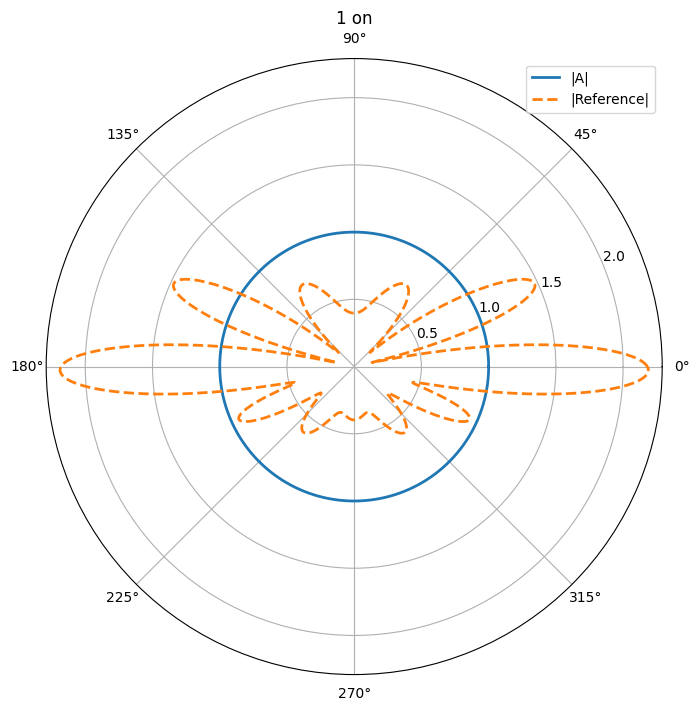

cost: 6.697191918626075


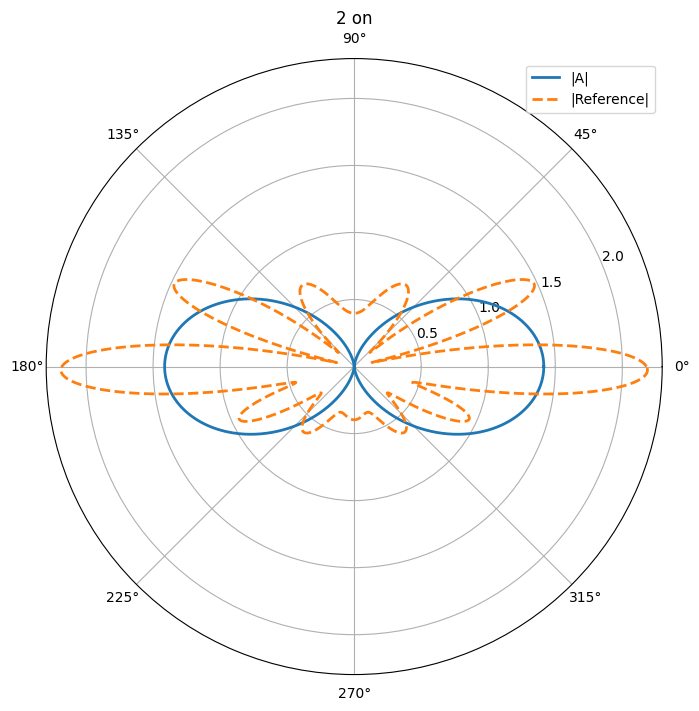

cost: 2.425034422622282


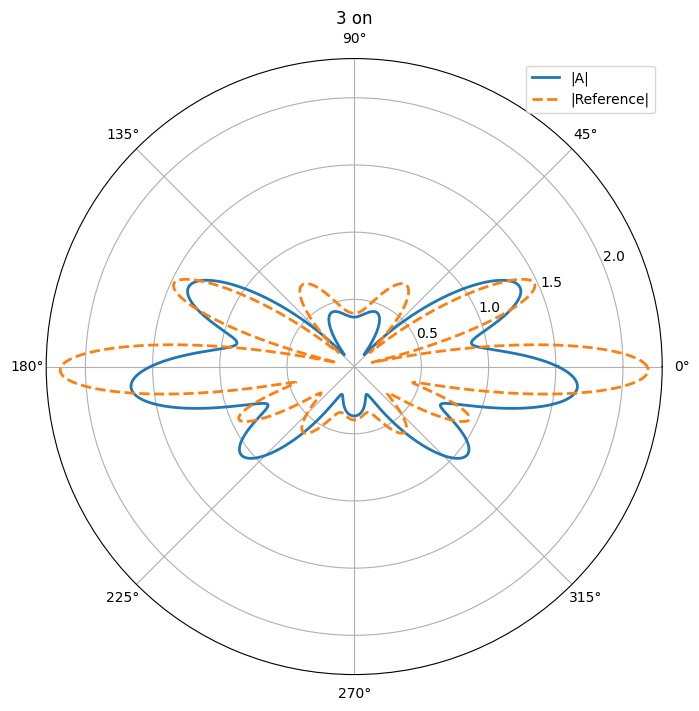

cost: 2.067188504742668


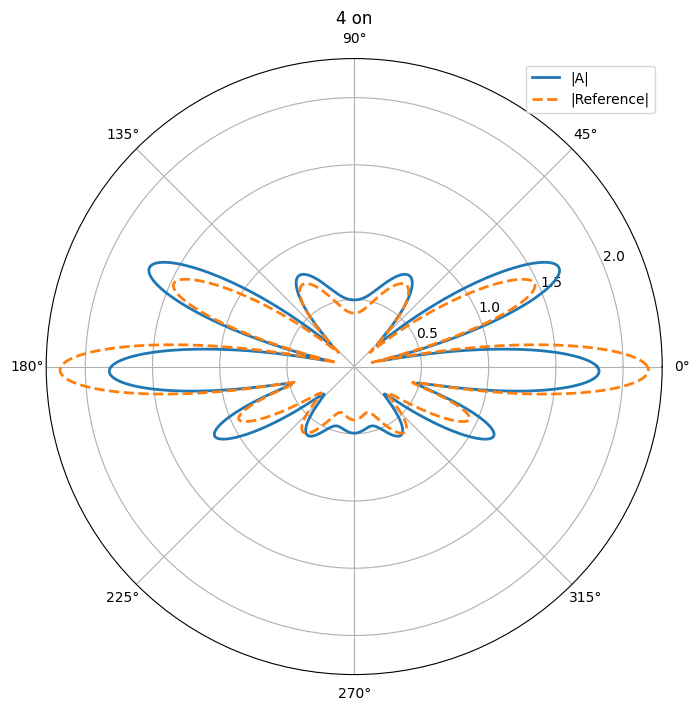

cost: 0.26445631639023487


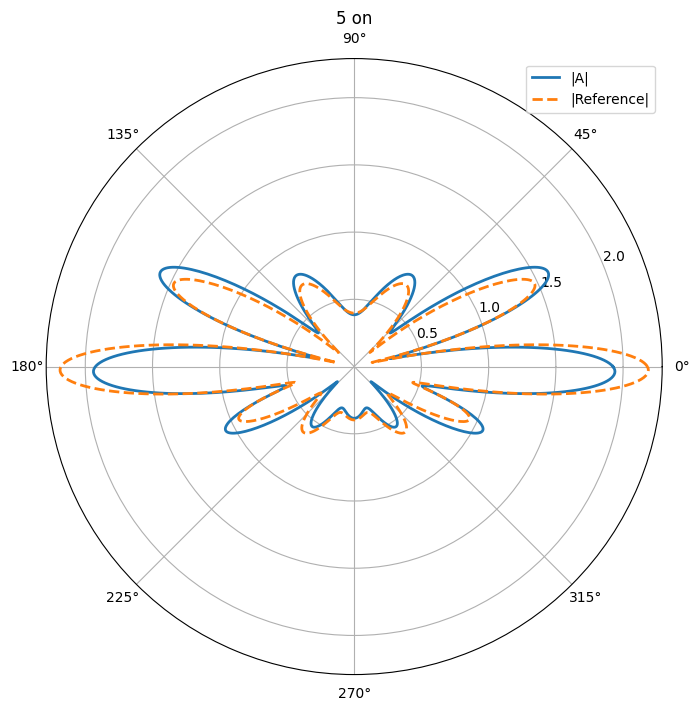

cost: 0.1845226808550955
[0 0 1 1 0 1 1 1]


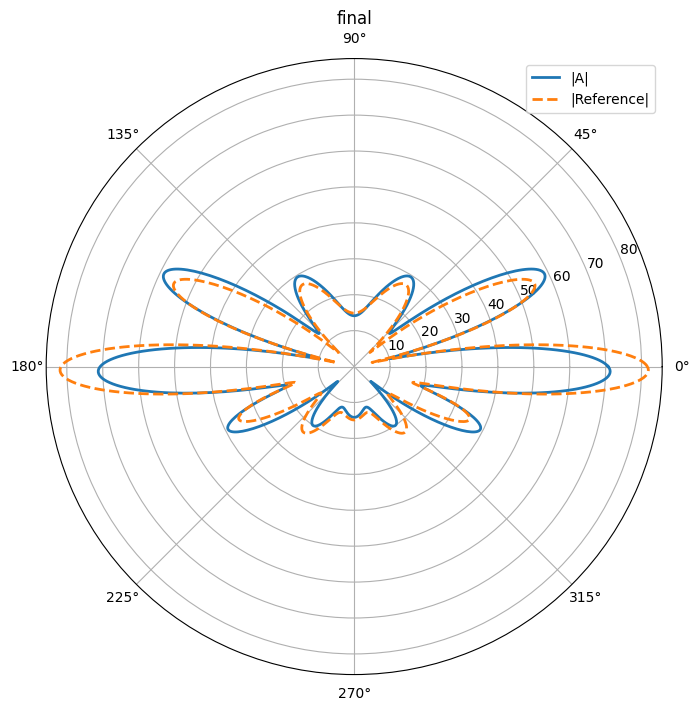

In [111]:
# turn off all antennas, then turn on one by one based on IQFT probability

threshold = 0.2

new_bit_list = np.array([0] * len(b_list))
for i in range(len(sorted_qubits)):
  new_bit_list[sorted_qubits[i]] = 1
  input_list = new_bit_list * weight_list
  input_list_normalized = input_list / np.linalg.norm(input_list)
  new_ref = antenna_pattern(input_list_normalized, f"{i+1} on", A_normalized)
  cost = cost_function(A_normalized, new_ref)
  print(f"cost: {cost_function(A_normalized, new_ref)}")
  if cost < threshold:
    print(new_bit_list)
    unnormalized_array = antenna_pattern(input_list, "final", A_actual)
    break

